# BASIC CONFIGURATIONS

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths
from dataDebug import dataDebug

import ePix320kM as devBoard

import pyrogue.protocols
import pyrogue.utilities.fileio
import rogue

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
# If crashes, make sure the deve is correct.
root =  devBoard.Root(   
        top_level  = top_level,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        pciePgpEn  = True,
        justCtrl   = False,
        DDebugSize = 4000)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
Root.pciePgp.AxiPcieCore.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1010700
UpTime       = 0:28:49
GitHash      = dirty (uncommitted code)
XilinxDnaId  = 0x400200000139d7204c70e105
FwTarget     = "ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Wed 10 Apr 2024 07:06:24 PM PDT
Builder      = dnajjar"
###################################################


In [3]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,0,1,0])

Rysync ASIC started
Did not find specific ASIC1 file. Using generic.
Did not find specific ASIC2 file. Using generic.
Did not find specific ASIC3 file. Using generic.
Did not find specific ASIC4 file. Using generic.
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_cb000018f0322301_SspMonGrp_carrier.yml
Loading waveforms configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_RegisterControl.yml
Loading batcher configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM32

In [4]:
run helperFunctions.ipynb

In [5]:
disableAllReceivers()

In [6]:
#get locked lanes
root.getLaneLocks()

ASIC0: 0xffffff
ASIC1: 0x0
ASIC2: 0x3effff
ASIC3: 0x0


In [7]:
printLaneMask()

ASIC0: 0x0
ASIC1: 0x0
ASIC2: 0xc10000
ASIC3: 0x0


In [8]:
#Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
root.Trigger()

ASIC:0 F#:57503 Mask:0x10000
ASIC:1 F#:57503 Mask:0xffffff
ASIC:2 F#:57503 Mask:0xc10000
ASIC:3 F#:57503 Mask:0xffffff


In [9]:
# Obtain descrambled single frame data from ASICs from DataReceiver. Data receiver is down sampled.
root.printDataReceiverStatus()
    
frame = [None for i in range(4)]
for asicIndex in range(4):
    frame[asicIndex] = getattr(root, f"DataReceiver{asicIndex}").Data.get()

Checkpoint: DataReceiver 0 has 1 frames
Checkpoint: DataReceiver 1 has 1 frames
Checkpoint: DataReceiver 2 has 1 frames
Checkpoint: DataReceiver 3 has 1 frames


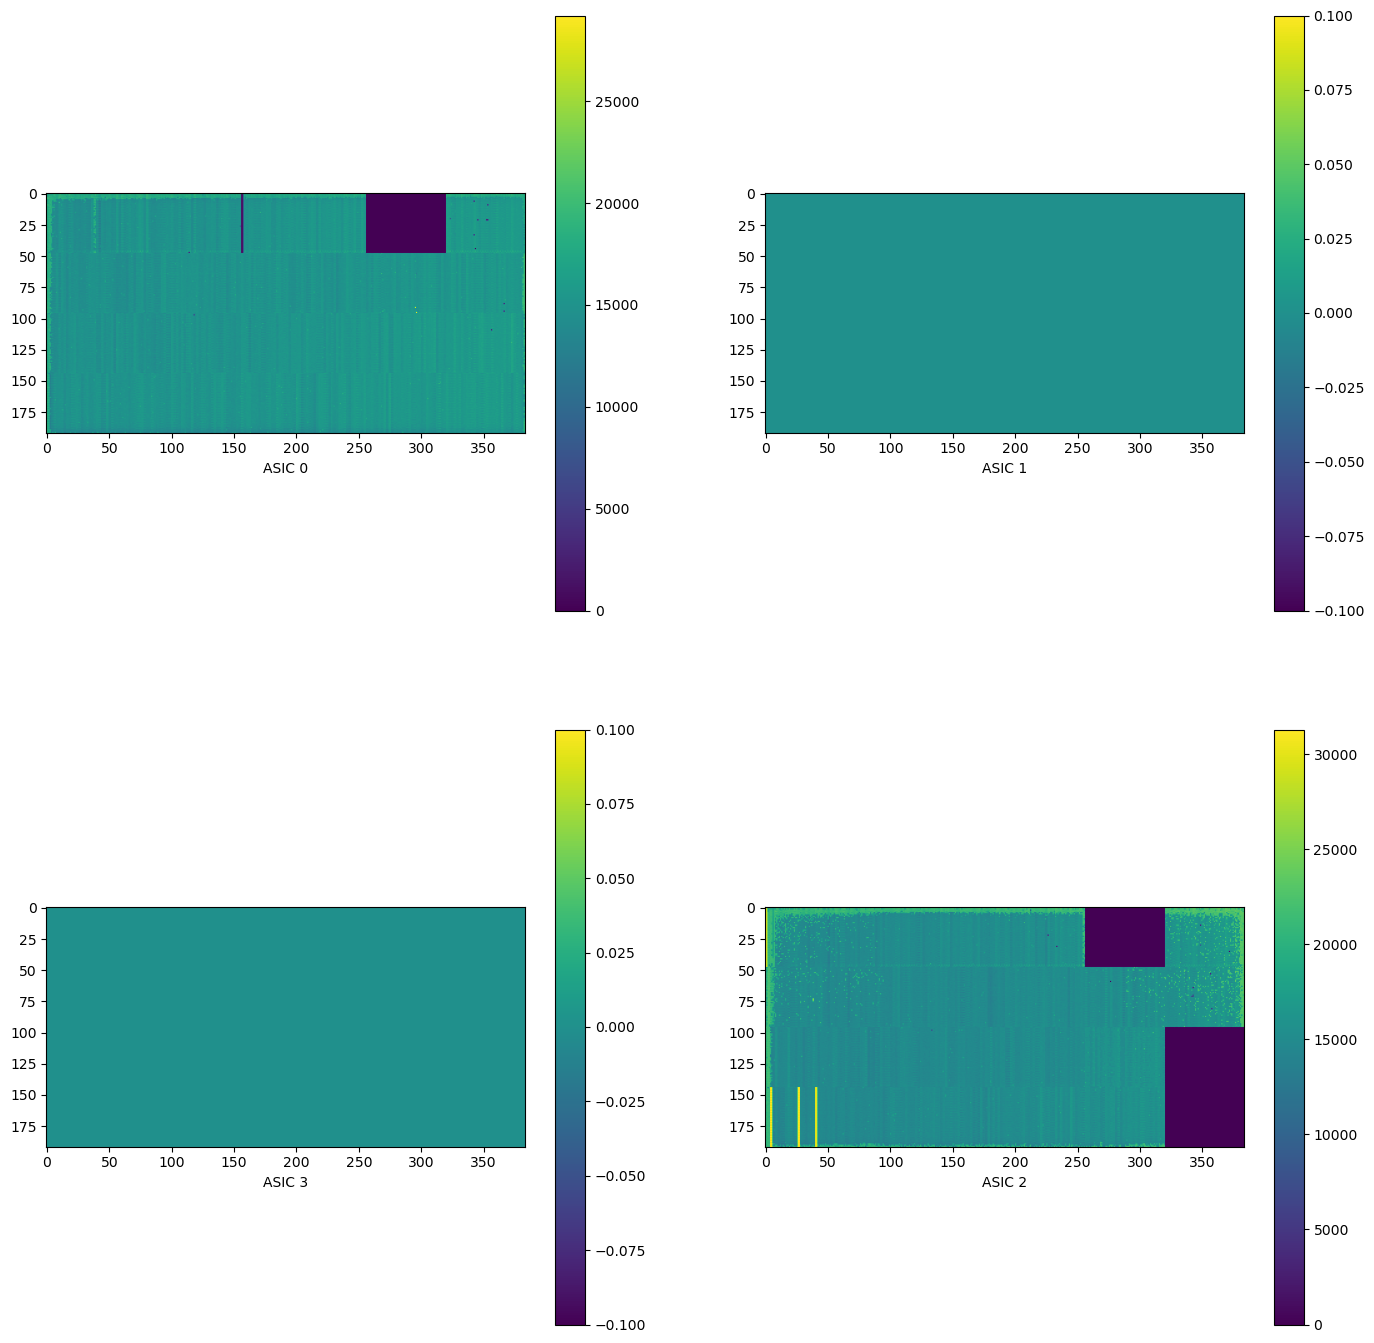

In [10]:
plotReceiverFrames()

# Pixel/ADCs optimal biasing

In [11]:
# Steps = clock period of 168Mhz (5.95ns)
# Acq1 is 20us
# R0 after Acq1
# R0 Width set to 1.920uS
# SR0 needs to be launched after R0 delay + R0 width + alpha



# ------------------- 20 us integration time
AcqWidth = 3125
AcqDelay = 260
#setAcq1(AcqWidth, AcqDelay)

R0Width = 3425
R0Delay = 100
#setR0(R0Width, R0Delay)

SR0Width = 38000
SR0Delay = R0Width + R0Delay + 10
#setSR0(SR0Width, SR0Delay)

# ------------------- 1 us integration time
AcqWidth = 160
AcqDelay = 260
#setAcq1(AcqWidth, AcqDelay)

R0Width = 3425
R0Delay = 100
#setR0(R0Width, R0Delay)

SR0Width = 38000
SR0Delay = R0Width + R0Delay + 10
#setSR0(SR0Width, SR0Delay)

# Print human-readable values
print(f'-------------------------')
baseline_int_time = REGCTRL.AcqDelay1_us.get() - REGCTRL.R0Delay_us.get()
integration_time = REGCTRL.AcqWidth1_us.get()
print(f'Baseline time:    {baseline_int_time} uS')
print(f'Integration time: {integration_time} uS')
print(f'Sampling done at: {REGCTRL.AcqWidth1_us.get()+REGCTRL.AcqDelay1_us.get()} uS')
print(f'-------------------------')

-------------------------
Baseline time:    3.6031999999999997 uS
Integration time: 3.6032 uS
Sampling done at: 7.2704 uS
-------------------------


In [12]:
# Set optimal values for Pixel analog references
#ASIC3.RefinN.set(4)
#ASIC3.RefinP.set(4)

# ADC settings
#ASIC3.DHg.set(True)    # Set High gain
#ASIC3.S2D_1_b.set(0)   # Set bias current to max (min value)
#ASIC3.Ref_gen_d.set(2) # Set 'common-mode' voltage of S/H stage
#ASIC3.RefGenB.set(2)   # Don't touch

# Pixel gain mode - Select operation mode

In [13]:
# Uncomment for Fixed High-Gain
# Set threshold to the minimum voltage (maximum energy, should not switch)
#ASIC3.CompTH_ePixM.set(0)
#ASIC3.Precharge_DAC_ePixM.set(40)

# Uncomment for Fixed Low-Gain
# ASIC3.CompTH_ePixM.set(63)
# ASIC3.Precharge_DAC_ePixM.set(50)

# Uncomment for Augo-Gain switching
# Set threshold to the minimum voltage (maximum energy, should not switch)
# ASIC3.CompTH_ePixM.set(10)
# ASIC3.Precharge_DAC_ePixM.set(40)


# Writing data to a rogue format file on full rate

In [17]:
test = 50

In [18]:
clearUpStreamPpg()
clearDownStreamPpg()
clearSspMonGrp()
clearDigAsicStrmReg()
disablePpgFlowCtrl(True)

In [20]:
root.enableDataRcv(False)
root.disableAndCleanAllFullRateDataRcv()
root.enableAllAsics(False)
root.enableDataDebug(False)

root.enableAsic(0, True)
root.enableAsic(2, True)

ssdPath = "/u1/ePixHRM320k/acquisition"
filename = f"{ssdPath}/test{test}.dat"
rate = 5000 # HZ
frames = 30000
test = test + 1
root.acquireToFile(filename, frames, rate)

Acquisition started: filename: /u1/ePixHRM320k/acquisition/test51.dat, rate: 5000, #frames:30000
Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 30000
Stop Triggers command executed
Received on channel 0 18374 frames...
Received on channel 1 0 frames...
Received on channel 2 18386 frames...
Received on channel 3 0 frames...
Waiting for file to close...
Acquisition complete and file closed
Rogue/pyrogue version v6.1.3. https://github.com/slaclab/rogue
1712809071.295265:pyrogue.batcher.CoreV1: Not enough space (37344) for frame (977485200)
1712809071.295324:pyrogue.batcher.CoreV1: Not enough space (96960) for frame (147552)
1712809071.295326:pyrogue.batcher.CoreV1: Not enough space (37344) for frame (897071664)
1712809071.295381:pyrogue.batcher.CoreV1: Not enough space (104720) for frame (147552)
1712809071.295383:pyrogue.batcher.CoreV1: Not enough space (36576) for frame (954547216)
1712809071.295477:pyrogue.batcher.Cor

In [17]:
getPKREGCounters([1,0,1,0])
getUpStreamPpgFrmCnt()
getDownStreamPpgFrmCnt()

DigAsicStrmRegister0 FrameCount=43534 disable=0x0
ASIC 0 Lane 0 is having 71 timeouts
ASIC 0 Lane 0 is having overflow of 65535
ASIC 0 Lane 1 is having 88 timeouts
ASIC 0 Lane 1 is having overflow of 65535
ASIC 0 Lane 2 is having 88 timeouts
ASIC 0 Lane 2 is having overflow of 65535
ASIC 0 Lane 3 is having 45 timeouts
ASIC 0 Lane 3 is having overflow of 65535
ASIC 0 Lane 4 is having 88 timeouts
ASIC 0 Lane 4 is having overflow of 65535
ASIC 0 Lane 5 is having 21 timeouts
ASIC 0 Lane 5 is having overflow of 65535
ASIC 0 Lane 6 is having 21 timeouts
ASIC 0 Lane 6 is having overflow of 65535
ASIC 0 Lane 7 is having 88 timeouts
ASIC 0 Lane 7 is having overflow of 65535
ASIC 0 Lane 8 is having 71 timeouts
ASIC 0 Lane 8 is having overflow of 65535
ASIC 0 Lane 9 is having 21 timeouts
ASIC 0 Lane 9 is having overflow of 65535
ASIC 0 Lane 10 is having 21 timeouts
ASIC 0 Lane 10 is having overflow of 65535
ASIC 0 Lane 11 is having 71 timeouts
ASIC 0 Lane 11 is having overflow of 65535
ASIC 0 Lan

In [ ]:
readFromFile(filename)

In [ ]:
for i in range(numOfAsics):
    print("ASIC {}: Extracted {} frames".format(i,np.shape(readerReceiver[i].getData())[2]))

In [ ]:
for i in range(np.shape(readerReceiver[0].getData())[2]) :
    print("fixedMask for ASIC 0 frame {} is {}".format(i, hex(readerReceiver[0].getMetaData()[0]['autoFillMask'])))
    print("autoFillMask for ASIC 2 frame {} is {}".format(i, hex(readerReceiver[2].getMetaData()[0]['autoFillMask'])))